In [1]:
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from scipy import stats

In [2]:
set_matplotlib_formats("svg")

In [3]:
cmap = plt.get_cmap("tab10")

## Parameters

In [4]:
NOTEBOOK_PATH = Path("99_lightgbm_example").resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)

NOTEBOOK_PATH

PosixPath('/home/kimlab4/strokach/workspace/elaspic-v2/notebooks/99_lightgbm_example')

## Test 1

In [5]:
train_data = lgb.Dataset("rank.train", group="rank.train.query")
validation_data = lgb.Dataset("rank.test", group="rank.train.query")

In [6]:
train_data = lgb.Dataset("rank.train")
validation_data = lgb.Dataset("rank.test")

In [7]:
params = {
    #
    "objective": "lambdarank",  # "rank_xendcg",
    "metric": "ndcg",
    "eval_at": 1_000_000,
}
bst = lgb.train(params, train_data, num_boost_round=200, early_stopping_rounds=10, valid_sets=[validation_data], verbose_eval=False)

[LightGBM] [Info] Loading query boundaries...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6187
[LightGBM] [Info] Number of data points in the train set: 3005, number of used features: 215
[LightGBM] [Info] Loading query boundaries...


## Test 2

In [63]:
x1 = np.arange(0, 20, 2)
y1 = np.arange(0, 20, 2)

x2 = np.arange(1, 21, 2)
y2 = np.arange(1, 21, 2) * 10

gp = np.array([0] * len(x1) + [1] * len(x2))

validation_df = pd.DataFrame({"x": np.r_[x1, x2], "y": np.r_[y1, y2], "gp": gp}, index=np.arange(20))

num_repeats = 20
train_df = pd.concat([validation_df] * num_repeats, ignore_index=True)
train_df["x"] = train_df["x"].values + np.random.randn(len(train_df)) * 0.1
train_df = train_df.sort_values(["gp", "x"])
train_df.head()

,x,y,gp
200,-0.163648,0,0
380,-0.145580,0,0
260,-0.138111,0,0
40,-0.120887,0,0
80,-0.094840,0,0


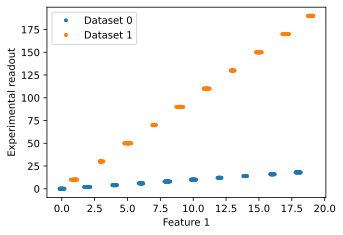

In [64]:
def plot_training_data(ax):
    ax.plot(
        train_df[train_df["gp"] == 0]["x"],
        train_df[train_df["gp"] == 0]["y"],
        ".",
        color=cmap(0),
        markersize=6,
        label="Dataset 0",
    )
    ax.plot(
        train_df[train_df["gp"] == 1]["x"],
        train_df[train_df["gp"] == 1]["y"],
        ".",
        color=cmap(1),
        markersize=6,
        label="Dataset 1",
    )
    ax.legend()


fg, ax = plt.subplots(figsize=(5, 3.5))
ax.set_xlabel("Feature 1")
ax.set_ylabel("Experimental readout")
plot_training_data(ax)
fg.savefig(NOTEBOOK_PATH.joinpath("input-data.svg"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("input-data.png"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("input-data.pdf"), dpi=300)

In [65]:
df1 = train_df[train_df["gp"] == 0]
df2 = train_df[train_df["gp"] == 1]

train_data = lgb.Dataset(data=train_df[["x"]], label=train_df[["y"]], group=[len(df1), len(df2)])

validation_data_lst = [
    lgb.Dataset(data=df1[["x"]], label=df1[["y"]], group=[len(df1)]),
    lgb.Dataset(data=df2[["x"]], label=df2[["y"]], group=[len(df2)]),
]

### Least squares

In [66]:
params = {
    #
    "objective": "regression",  # "lambdarank",  # "rank_xendcg",
    "metric": "l2",
    "num_leaves": 1000,
    "learning_rate": 0.1,
    "max_bin": 10000,
    "min_data_in_bin": 1,
    "max_depth": 20,
    "min_data_in_leaf": 4,
    "max_depth": 1,
}
bst = lgb.train(
    params,
    train_data,
    num_boost_round=5_000,
    early_stopping_rounds=100,
    valid_sets=validation_data_lst,
    verbose_eval=False,
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 1
[LightGBM] [Info] Start training from score 54.500000


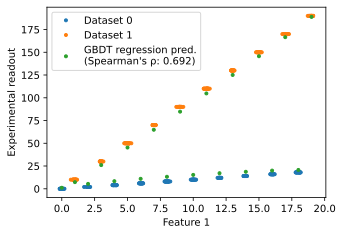

In [67]:
ypred = bst.predict(validation_df[["x"]], num_iteration=bst.best_iteration)
corr = stats.spearmanr(validation_df["x"], ypred)

fg, ax = plt.subplots(figsize=(5, 3.5))
plot_training_data(ax)
ax.plot(
    validation_df["x"],
    ypred,
    ".",
    color=cmap(2),
    label=f"GBDT regression pred.\n(Spearman's ρ: {corr[0]:.3f})",
)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Experimental readout")
ax.legend()
fg.savefig(NOTEBOOK_PATH.joinpath("regression-fit.svg"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("regression-fit.png"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("regression-fit.pdf"), dpi=300)

In [98]:
params = {
    #
    "objective": "lambdarank",  # "rank_xendcg",
    "metric": "ndcg",
    "eval_at": 1_000_000,
    "label_gain": [i for i in range(0, 1000)],
#     "label_gain": [0] + [(2**i - 1) for i in range(0, 1000)],
#     "label_gain": [np.log2(2 + i) for i in range(0, 1001)],
#     "label_gain": [np.log2(2) for i in range(0, 1000)],
    #
    "num_leaves": 3000,
    "learning_rate": 0.4,
#     "max_bin": 2,
    "max_depth": 2,
    "min_data_in_leaf": 4,
    "max_depth": 1,
}
bst = lgb.train(
    params,
    train_data,
#     feval=lambda preds, train_data: ("sp", stats.spearmanr(preds.squeeze(), train_data.label.squeeze())[0], True),
    num_boost_round=4_000,
    early_stopping_rounds=200,
    valid_sets=validation_data_lst,
    verbose_eval=False
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 1


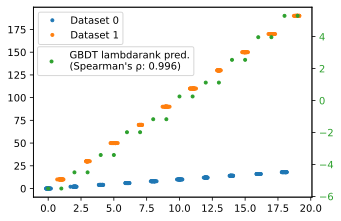

In [99]:
ypred = bst.predict(validation_df[["x"]], num_iteration=bst.best_iteration)
corr = stats.spearmanr(validation_df["x"], ypred)

fg, ax = plt.subplots(figsize=(5, 3.5))
plot_training_data(ax)
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(
    validation_df["x"],
    ypred,
    ".",
    color=cmap(2),
    label=f"GBDT lambdarank pred.\n(Spearman's ρ: {corr[0]:.3f})",
)
ax2.tick_params(axis="y", labelcolor=cmap(2))
ax2.legend(loc=(0.015, 0.64))
fg.savefig(NOTEBOOK_PATH.joinpath("lambdarank-fit.svg"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("lambdarank-fit.png"), dpi=300)
fg.savefig(NOTEBOOK_PATH.joinpath("lambdarank-fit.pdf"), dpi=300)

In [15]:
import numpy as np
import torch
from scipy import sparse

In [16]:
def permute_iterchain(row_or_col, p1_lenght, p2_length, offset):
    mask = row_or_col >= p1_length
    row_or_col[mask] = row_or_col[mask] + offset
    row_or_col[mask] = np.where(
        row_or_col[mask] < p1_length, row_or_col[mask] + p2_length, row_or_col[mask]
    )
    row_or_col[mask] = np.where(
        row_or_col[mask] >= (p1_length + p2_length), row_or_col[mask] - p2_length, row_or_col[mask]
    )
    return row_or_col

In [17]:
p1_length = 100
p2_length = 50
mat_dense = torch.zeros((p1_length + p2_length, p1_length + p2_length))
mat_dense[np.arange(0, p2_length), np.arange(p1_length, p1_length + p2_length)] = 1
mat_dense[np.arange(p1_length, p1_length + p2_length), np.arange(0, p2_length)] = 1

-25


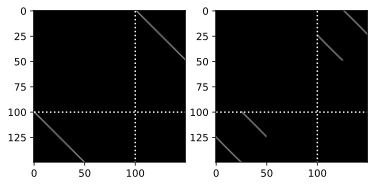

In [18]:
offset = np.random.randint(6, p2_length - 6) * np.random.choice([-1, 1])
print(offset)

mat_sparse = sparse.coo_matrix(mat_dense)
row = permute_iterchain(mat_sparse.row.copy(), p1_length, p2_length, offset)
col = permute_iterchain(mat_sparse.col.copy(), p1_length, p2_length, offset)
mat_sparse_permutted = sparse.coo_matrix((mat_sparse.data, (row, col)))
assert np.allclose(mat_sparse_permutted.todense(), mat_sparse_permutted.todense().T)

fg, axs = plt.subplots(1, 2)
axs[0].hlines(100, 0, 150, linestyle=":", color="white")
axs[0].vlines(100, 0, 150, linestyle=":", color="white")
axs[0].imshow(mat_sparse.todense(), cmap="gray")

axs[1].hlines(100, 0, 150, linestyle=":", color="white")
axs[1].vlines(100, 0, 150, linestyle=":", color="white")
axs[1].imshow(mat_sparse_permutted.todense(), cmap="gray")